## Imports

In [1]:
from wcs_helper_functions import *
import numpy as np
from scipy import stats, spatial
from random import random
import pandas as pd
from sklearn.model_selection import LeaveOneOut
import matplotlib.pyplot as plt
%matplotlib inline

## Read Data

In [2]:
fociData = readFociData('./WCS_data_core/foci-exp.txt');
namingData = readNamingData('./WCS_data_core/term.txt');
cielabCoord = readClabData('./WCS_data_core/cnum-vhcm-lab-new.txt');
munsellInfo = readChipData('./WCS_data_core/chip.txt');
indexCoord = munsellInfo[1]

## Helper Functions

In [3]:
def empty_frequency_map():
    f_map = {
                "A":[0]*41,
                "B":[0]*41,
                "C":[0]*41,
                "D":[0]*41,
                "E":[0]*41,
                "F":[0]*41,
                "G":[0]*41,
                "H":[0]*41,
                "I":[0]*41,
                "J":[0]*41
    }
    return f_map

def f_map_to_matrix(f_map):
    """
    Take a frequency map (dictionary) and turn it into a matrix
    """
    matrix = [f_map["A"],
              f_map["B"],
              f_map["C"],
              f_map["D"],
              f_map["E"],
              f_map["F"],
              f_map["G"],
              f_map["H"],
              f_map["I"],
              f_map["J"]]
    # manually setting these to zero as they are achromatic
    matrix[0][0] = 0
    matrix[9][0] = 0
    return matrix
    
def frequency_hit(f_map,x,y):
    """
    f_map is a frequency map
    x is the index (number)
    y is a letter
    """    
    f_map[y][x]+=1
    return f_map

def contour_plot(f_map):
    """
    Take a f_map as a matrix and plot it as a contour plot
    """
    f_map.reverse()
    x_size = range(0,41)
    y_size = range(0, 10)
    x, y = np.meshgrid(x_size, y_size)
    fig = plt.figure(figsize=(41, 10))
    ax = fig.add_axes([1,1,1,1]) 
    cp = ax.contour(x, y, f_map)
    ax.clabel(cp, inline=True, fontsize=10)
    ax.set_title('Contour Plot: Frequency Graph')
    ax.set_xlabel('Hue')
    ax.set_ylabel('Lightness')
    return plt

    

## Contour map of frequencies

In [4]:
f_map = empty_frequency_map()
# Indexing over languages
lang = []
for language_index in range(1, len(fociData)):
    # Indexing over people
    for person_index in range(1, len(fociData[language_index])):
        # Incase of missing data
        if person_index not in fociData[language_index]:
            continue
        # A persons foci data
        person_foci = fociData[language_index][person_index]
        for term in person_foci.values():
            for coord in term:   
                y,x = coord.split(":")
                x=int(x)
                frequency_hit(f_map,x,y)



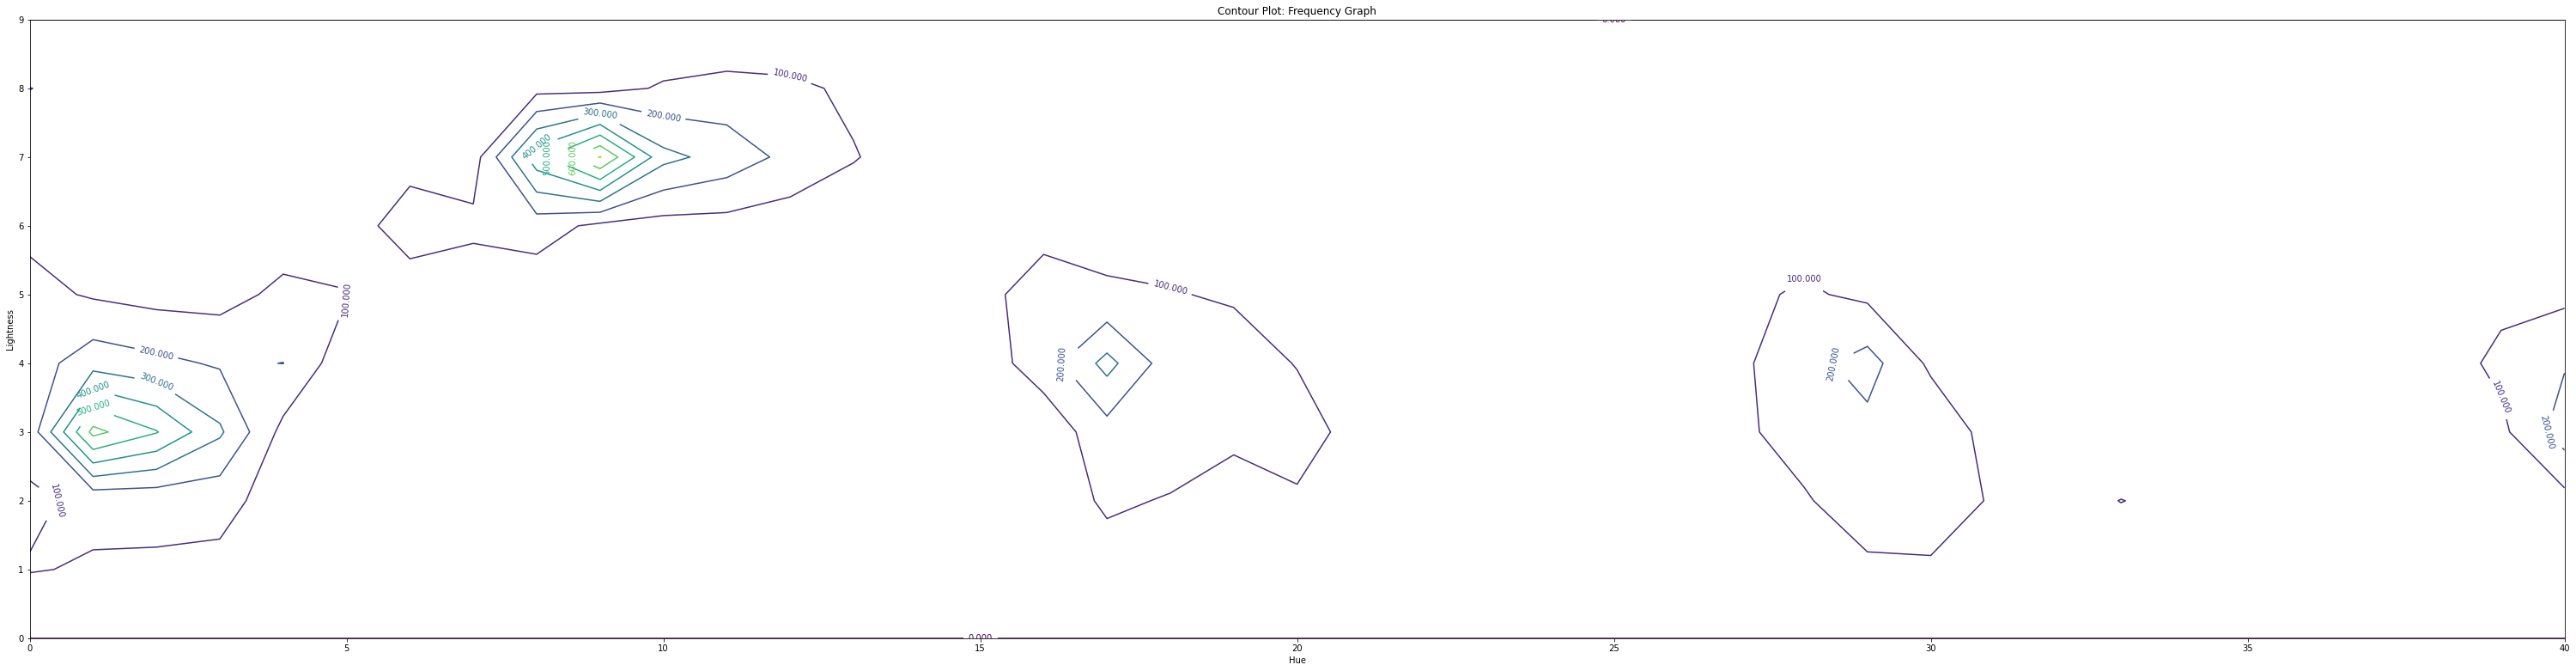

In [5]:
m = f_map_to_matrix(f_map)
graph = contour_plot(m)
graph.show()

## Prototype Model (Attempt)

This prototype attempt will get the cielab coordinates of all foci in a category and calculate the mean.

 ### Helper Functions

In [6]:
def get_coords_per_term():
    """
    create a list, where each index in the list is a new language.
    each item in the list will be a dictionary of terms used by that language with each term having a
    value which is a list of cielab coordinates selected for that term.
    ex: [{
        '*': [
        (0,0.3,1),
        ...
        ],
        ...
    },
    ...
    ]
    """
    lang_coord = []
    # for each language in naming data
    for language_index in range(1, len(namingData)):
        # Create a dictionary that will hold the terms (key) and list of coordinates (value)
        term_coord = {}
        # For each person in the language
        for person_index in range(1, len(namingData[language_index])):
            #  naming data missing an index
            if person_index not in namingData[language_index]:
                continue
                
            # A persons foci data
            person_naming = namingData[language_index][person_index] # Format { 1: 'YN', 2:'*', ...}
            for i in person_naming:
                term = person_naming[i]
                # term not in term_coord create a new list
                if term not in term_coord:
                    # create a key value pair where term is the key, and a list with a single coordinate 
                    # is the value
                    term_coord[term] = [cielabCoord[i]]
                # else append coordinate to existing list
                else:
                     term_coord[term].append(cielabCoord[i])

        lang_coord.append(term_coord)
    return lang_coord

def get_centroid(term_dict):
    """
    Takes in a list of CIELAB coordinates for a single term. Get centroid
    Returns a dictionary of terms as keys and centroid cielab coordinate as value
    """
    centroid_dict = {}
    for term in term_dict:
        coords = term_dict[term]
        mean = np.array(coords).astype(np.float).mean(axis=0)
        centroid_dict[term] = mean
    return centroid_dict
        
        
def find_nearest_example(point):
    """
    Given a CIELAB coordinate (point), use cielabCoord to find the chip with the nearest
    coordinate.
    Return the index of that closest chip
    """
    c_p_i = None # Closest point index
    closest_point = None
    min_d = None
    
    for k, v in cielabCoord.items():  # for name, age in dictionary.iteritems():  (for Python 2.x)
        point, v = comparable(point, v)
        d = spatial.distance.euclidean(v, point)
        if min_d == None or min_d > d:
            min_d = d
            closest_point = v
            c_p_i = k

    return c_p_i

def comparable(point, v):
    """
    take point looking like
    v:  ('96.00', '-.06', '.06')
    point:  [ 37.36797663 -13.71869357   1.733829  ]
    make them comparable in spatial.distance.euclidean()
    """
    p = (point[0], point[1], point[2])
    v = (float(v[0]), float(v[1]), float(v[2]))
    return p ,v



### Model

labels are the ground truth that we will predict.
I guess that means labels should be what that language said is foci?

In [7]:

def prototype_f_map(data):
    """
    Data is what get_coords_per_term() returns... a list, where each index in the list is a new language.
    each item in the list will be a dictionary of terms used by that language with each term having a
    value which is a list of cielab coordinates selected for that term.
    
    Creates and returns a frequency map that is populated with the nearest chips to the prototype of a colour
    category/term marked as frequency hits.
    """
    # Initialize an empty frequency map
    f_map = empty_frequency_map()

    # for each language in the data
    for i in range(len(data)):
        term_dict = data[i]
        # get the dictionary of all centroids for a term
        centroid_dict = get_centroid(term_dict)
        # For each centroid coordinate, find the closest cielab point from chips
        for centroid in centroid_dict.values():
            closest_point_index = find_nearest_example(centroid)
            y , x = indexCoord[closest_point_index] # This is a hit x is index y letter
            x = int(x)
            frequency_hit(f_map,x,y)
    return f_map

def prototype_model(train, test):
    """
    train is a list of cielab coordinates
    test in a cielab coordinate
    label is whether this test coordinate is close to
    the center 
    """
    

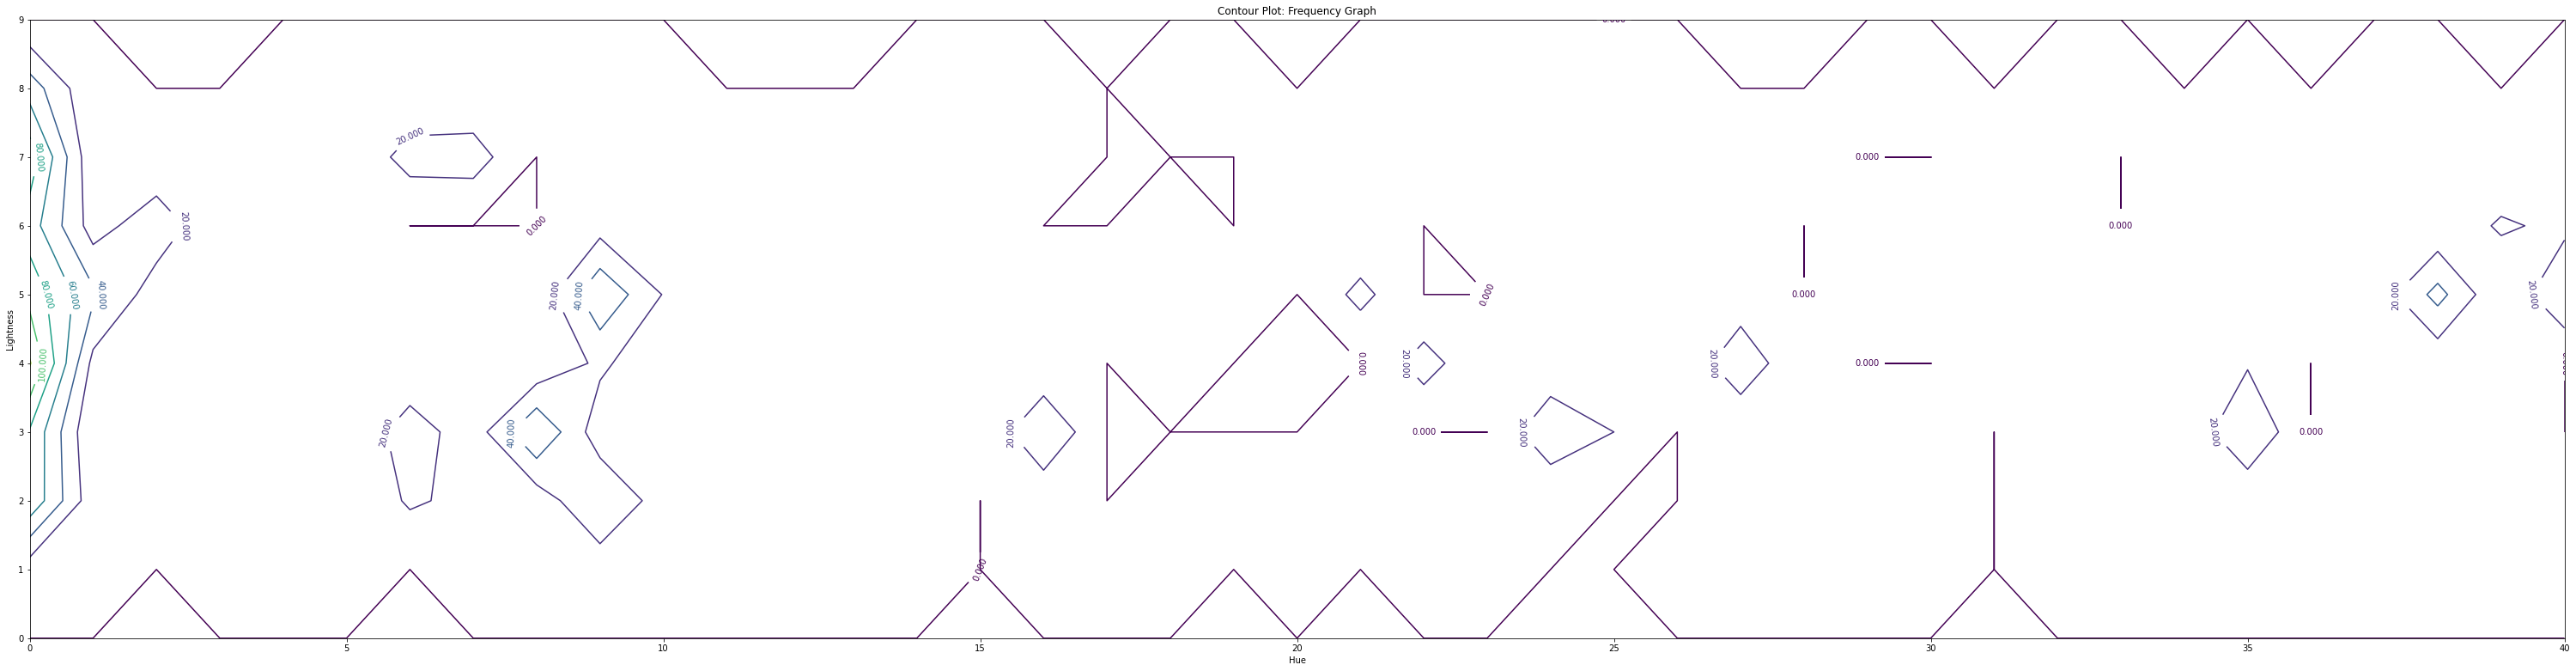

In [8]:
x = get_coords_per_term()
f_map = prototype_f_map(x)
m = f_map_to_matrix(f_map)
graph = contour_plot(m)
graph.show()

## Exemplar Model (attempt)

Idea for exemplar model. Find Cielab coordinate for all points in a term. The find the middle of those points and find nearest chip. This should be the exemplar

In [9]:
x = get_coords_per_term()

x is a list, where each index in the list is a new language. Each item in the list will be a dictionary of terms used by that language with each term having a value which is a list of cielab coordinates selected for that term

In [10]:
# def exemplar_model(data):

## Testing Models

### Helper Functions

In [13]:
def accuracy(correct_answers, predicted_answers):
    """
    Calculate the accuracy of the prediction
    """
    correct = 0
    for i in range(len(correct_answers)):
        if correct_answers[i] == predicted_answers[i]:
            correct += 1
    return correct / len(correct_answers)

def error_analysis(predicted_labels, correct_labels):
    difference = []
    for i in range(len(correct_labels)):
        if predicted_labels[i] != correct_labels[i]:
            difference = np.append(difference, names[i])
    return difference
    
def get_all_cielab_coord():
    all_coord = list(cielabCoord.values())
    return all_coord

Leave One Out

For each term, use loo to calculate how close all of the colour chips are to the focal point.

In [14]:
loo = LeaveOneOut()
all_coord = get_all_cielab_coord()
loo.get_n_splits(all_coord)

for train_i, test_i in loo.split(all_coord):
    train = all_coord[train_i]
    # Should mark labels here
    test = all_coord[test_i]
    
    # Correct data (focal points)
    """
    Get correct data by creating a list whic maps to all_coord
    The list will indicate whether a point is a focal point or not?
    """
    # Missing label stuff here
    prototype_prediction = prototype_model(train, test, label)
    
    

<class 'list'>
('96.00', '-.06', '.06')


NameError: name 'F' is not defined